In [1]:
pip install transformers pandas sklearn numpy

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from PIL import Image
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertConfig, BertModel
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [3]:
images = []
descriptions = []
emotions = []
emotion_dic = {"positive":2, "negative":1, "neutral":0}
e_dataframe = pd.read_csv("./data/train.txt")
pre_trained = 'bert-base-uncased'
token = BertTokenizer.from_pretrained(pre_trained)

for i in range(e_dataframe.shape[0]):
    try:
        idx = e_dataframe.iloc[i]['guid']
        emotion = e_dataframe.iloc[i]['tag']
        img = Image.open('./data/data/' + str(idx) + '.jpg')
        img = img.resize((224,224),Image.ANTIALIAS)
        image = np.asarray(img, dtype = 'float32')
        with open('./data/data/' + str(idx) + '.txt', encoding='gbk') as fp:
            description = fp.read()
        images.append(image.transpose(2,0,1))
        descriptions.append(description)
        emotions.append(emotion_dic[emotion])
    except:
        continue

In [4]:
pre_trained = 'bert-base-uncased'
token = BertTokenizer.from_pretrained(pre_trained)

In [ ]:
def text2emb(texts):
    data = token.batch_encode_plus(batch_text_or_text_pairs = texts, 
                                   truncation=True, padding='max_length', max_length=32,
                                   return_tensors='pt')
    input_ids = data['input_ids']
    attention_mask = data["attention_mask"]
    return input_ids, attention_mask

In [6]:
count = Counter(emotions)
print(count)

Counter({2: 2387, 1: 1193, 0: 419})


In [7]:
image_and_txt = [(images[i], descriptions[i]) for i in range(len(images))]
x_train, x_test, emotion_train, emotion_test = train_test_split(image_and_txt, emotions, test_size=0.2, random_state=0)
image_train, txt_train = [x_train[i][0] for i in range(len(x_train))], [x_train[i][1] for i in range(len(x_train))]
image_test, txt_test = [x_test[i][0] for i in range(len(x_test))], [x_test[i][1] for i in range(len(x_test))]

In [8]:
count = Counter(emotion_train)
print(count)

Counter({2: 1885, 1: 980, 0: 334})


In [9]:
class Lab5Dataset():
    def __init__(self, images, descriptions, emotions):
        self.images = images
        self.input_ids, self.attention_masks = text2emb(descriptions)
        self.emotions = emotions

    def __getitem__(self, index):
        image = self.images[index]
        input_id = self.input_ids[index]
        attention_mask = self.attention_masks[index]
        emotion = self.emotions[index]
        return image, input_id, attention_mask, emotion

    def __len__(self):
        return len(self.images)

In [10]:
train_dataset = Lab5Dataset(image_train, txt_train, emotion_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_dataset = Lab5Dataset(image_test, txt_test, emotion_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 16, shuffle = True)

### 仅使用图片，ResNet从头训练

In [94]:
class ResBlock(nn.Module):
    def __init__(self, in_channel, out_channel, stride=1):
        super(ResBlock, self).__init__()
        self.c1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=3, stride=stride, padding=1, bias=False)
        self.b1 = nn.BatchNorm2d(out_channel)
        self.a1 = nn.ReLU()
        self.c2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel, kernel_size=3, stride=1, padding=1, bias=False)
        self.b2 = nn.BatchNorm2d(out_channel)

        if stride != 1 or in_channel != out_channel:
            self.residual_path = nn.Sequential(
                nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=3, stride=stride, padding=1),
                nn.BatchNorm2d(out_channel)
            )
        else:
            self.residual_path = nn.Sequential()

    def forward(self, x):
        x_copy = x
        x = self.c1(x)
        x = self.b1(x)
        x = self.a1(x)
        x = self.c2(x)
        x = self.b2(x)
        x += self.residual_path(x_copy)
        x = torch.relu(x)
        return x

In [95]:
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.b1 = nn.BatchNorm2d(64)
        self.a1 = nn.ReLU()
        self.block_1_1 = ResBlock(64,64,1)
        self.block_1_2 = ResBlock(64,64,1)
        self.block_2_1 = ResBlock(64,128,2)
        self.block_2_2 = ResBlock(128,128,1)
        self.block_3_1 = ResBlock(128,256,2)
        self.block_3_2 = ResBlock(256,256,1)
        self.block_4_1 = ResBlock(256,512,2)
        self.block_4_2 = ResBlock(512,512,1)
        self.p1 = nn.MaxPool2d(kernel_size=28)
        self.f1 = nn.Linear(512, 3)

    def forward(self, x):
        x = self.c1(x)
        x = self.b1(x)
        x = self.a1(x)
        x = self.block_1_1(x)
        x = self.block_1_2(x)
        x = self.block_2_1(x)
        x = self.block_2_2(x)
        x = self.block_3_1(x)
        x = self.block_3_2(x)
        x = self.block_4_1(x)
        x = self.block_4_2(x)
        x = self.p1(x)
        x = x.view(x.size(0), -1)
        x = self.f1(x)
        return x

In [96]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ResNet().to(device)
optimizer = optim.AdamW(model.parameters(), lr = 1e-5)
Loss = nn.CrossEntropyLoss()
train_acc = []
test_acc = []
for epoch in range(15):
    for batch_idx, (data, _, _,target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        optimizer.zero_grad()
        loss = Loss(output, target)
        loss.backward()
        optimizer.step()
        if (batch_idx + 1) % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx+1, len(train_dataloader), 100. * (batch_idx+1) / len(train_dataloader), loss.item()))

    correct = 0
    for data, _, _, target in train_dataloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        correct += int(pred.eq(target).sum())
    train_acc.append(correct / len(image_train))
    print('Train Accuracy: {:.6f}'.format(correct / len(image_train)))

    correct = 0
    for data, _, _, target in test_dataloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        correct += int(pred.eq(target).sum())
    test_acc.append(correct / len(image_test))
    print('Test Accuracy: {:.6f}'.format(correct / len(image_test)))

Train Epoch: 0 [50/200 (25%)]	Loss: 1.000729
Train Epoch: 0 [100/200 (50%)]	Loss: 1.004288
Train Epoch: 0 [150/200 (75%)]	Loss: 0.938234
Train Epoch: 0 [200/200 (100%)]	Loss: 0.842504
Train Accuracy: 0.659269
Test Accuracy: 0.613750
Train Epoch: 1 [50/200 (25%)]	Loss: 0.997234
Train Epoch: 1 [100/200 (50%)]	Loss: 1.065121
Train Epoch: 1 [150/200 (75%)]	Loss: 1.075928
Train Epoch: 1 [200/200 (100%)]	Loss: 0.913302
Train Accuracy: 0.741482
Test Accuracy: 0.563750
Train Epoch: 2 [50/200 (25%)]	Loss: 0.647955
Train Epoch: 2 [100/200 (50%)]	Loss: 0.675929
Train Epoch: 2 [150/200 (75%)]	Loss: 0.719715
Train Epoch: 2 [200/200 (100%)]	Loss: 0.468721
Train Accuracy: 0.820569
Test Accuracy: 0.566250
Train Epoch: 3 [50/200 (25%)]	Loss: 0.499807
Train Epoch: 3 [100/200 (50%)]	Loss: 0.390855
Train Epoch: 3 [150/200 (75%)]	Loss: 0.507999
Train Epoch: 3 [200/200 (100%)]	Loss: 0.507886
Train Accuracy: 0.879650
Test Accuracy: 0.571250
Train Epoch: 4 [50/200 (25%)]	Loss: 0.453007
Train Epoch: 4 [100/200

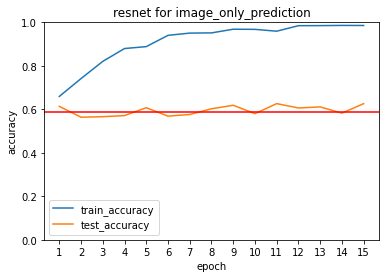

In [97]:
plt.plot(train_acc, label="train_accuracy")
plt.plot(test_acc, label="test_accuracy")
plt.axhline(Counter(emotion_train)[2]/len(emotion_train), color='red')
plt.title("resnet for image_only_prediction")
plt.xlabel("epoch")
plt.xticks(range(15), range(1, 16))
plt.ylabel("accuracy")
plt.ylim(ymin=0, ymax=1)
plt.legend()
plt.savefig('./image_only_prediction.jpg')
plt.show()

### 仅使用文本，BERT微调

In [11]:
class Bert(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.linear1 = nn.Linear(768, 256)
        self.linear2 = nn.Linear(256, 3)

    def forward(self, input_ids, input_mask):
        out = self.bert(input_ids = input_ids, attention_mask = input_mask) 
        out = out.last_hidden_state[:,0,:]
        out.view(out.shape[0], -1)
        out = self.linear1(out)
        out = self.linear2(out)
        return out

In [99]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Bert().to(device)
optimizer = optim.AdamW(model.parameters(), lr = 1e-6)
Loss = nn.CrossEntropyLoss()
train_acc = []
test_acc = []
for epoch in range(15):
    for batch_idx, (_, idx, mask, target) in enumerate(train_dataloader):
        idx, mask, target = idx.to(device), mask.to(device), target.to(device)
        output = model(idx, mask)
        optimizer.zero_grad()
        loss = Loss(output, target)
        loss.backward()
        optimizer.step()
        if (batch_idx + 1) % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx+1, len(train_dataloader), 100. * (batch_idx+1) / len(train_dataloader), loss.item()))

    correct = 0
    for _, idx, mask, target in train_dataloader:
        idx, mask, target = idx.to(device), mask.to(device), target.to(device)
        output = model(idx, mask)
        pred = output.argmax(dim=1)
        correct += int(pred.eq(target).sum())
    train_acc.append(correct / len(image_train))
    print('Train Accuracy: {:.6f}'.format(correct / len(image_train)))

    correct = 0
    for _, idx, mask, target in test_dataloader:
        idx, mask, target = idx.to(device), mask.to(device), target.to(device)
        output = model(idx, mask)
        pred = output.argmax(dim=1)
        correct += int(pred.eq(target).sum())
    test_acc.append(correct / len(image_test))
    print('Test Accuracy: {:.6f}'.format(correct / len(image_test)))
    
torch.save(model.state_dict(), "./bert.kpl")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train Epoch: 0 [50/200 (25%)]	Loss: 0.905487
Train Epoch: 0 [100/200 (50%)]	Loss: 0.979058
Train Epoch: 0 [150/200 (75%)]	Loss: 0.826418
Train Epoch: 0 [200/200 (100%)]	Loss: 0.777990
Train Accuracy: 0.589247
Test Accuracy: 0.627500
Train Epoch: 1 [50/200 (25%)]	Loss: 0.805751
Train Epoch: 1 [100/200 (50%)]	Loss: 1.089323
Train Epoch: 1 [150/200 (75%)]	Loss: 0.796537
Train Epoch: 1 [200/200 (100%)]	Loss: 0.910792
Train Accuracy: 0.627071
Test Accuracy: 0.661250
Train Epoch: 2 [50/200 (25%)]	Loss: 0.614145
Train Epoch: 2 [100/200 (50%)]	Loss: 0.776390
Train Epoch: 2 [150/200 (75%)]	Loss: 0.885749
Train Epoch: 2 [200/200 (100%)]	Loss: 0.802132
Train Accuracy: 0.692091
Test Accuracy: 0.698750
Train Epoch: 3 [50/200 (25%)]	Loss: 0.410786
Train Epoch: 3 [100/200 (50%)]	Loss: 0.734399
Train Epoch: 3 [150/200 (75%)]	Loss: 0.768556
Train Epoch: 3 [200/200 (100%)]	Loss: 0.723005
Train Accuracy: 0.743982
Test Accuracy: 0.717500
Train Epoch: 4 [50/200 (25%)]	Loss: 0.592835
Train Epoch: 4 [100/200

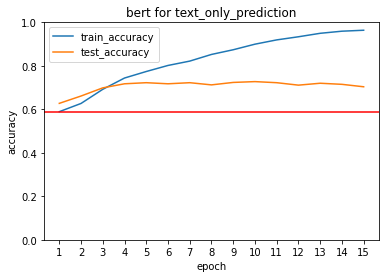

In [ ]:
plt.plot(train_acc, label="train_accuracy")
plt.plot(test_acc, label="test_accuracy")
plt.axhline(Counter(emotion_train)[2]/len(emotion_train), color='red')
plt.title("bert for text_only_prediction")
plt.xlabel("epoch")
plt.xticks(range(15), range(1, 16))
plt.ylabel("accuracy")
plt.ylim(ymin=0, ymax=1)
plt.legend()
plt.savefig('./text_only_prediction.jpg')
plt.show()

### 仅使用图片，RESNET预训练做linear probe

In [11]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1000,128)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(128,3)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LinearModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr = 1e-3)
Loss = nn.CrossEntropyLoss()
resnet = torchvision.models.resnet18(pretrained=True)
resnet.to(device)
train_acc = []
test_acc = []
for epoch in range(25):
    for batch_idx, (data, _, _,target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        data = resnet(data)
        output = model(data)
        optimizer.zero_grad()
        loss = Loss(output, target)
        loss.backward()
        optimizer.step()
        if (batch_idx + 1) % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx+1, len(train_dataloader), 100. * (batch_idx+1) / len(train_dataloader), loss.item()))

    correct = 0
    for data, _, _, target in train_dataloader:
        data, target = data.to(device), target.to(device)
        data = resnet(data)
        output = model(data)
        pred = output.argmax(dim=1)
        correct += int(pred.eq(target).sum())
    train_acc.append(correct / len(image_train))
    print('Train Accuracy: {:.6f}'.format(correct / len(image_train)))

    correct = 0
    for data, _, _, target in test_dataloader:
        data, target = data.to(device), target.to(device)
        data = resnet(data)
        output = model(data)
        pred = output.argmax(dim=1)
        correct += int(pred.eq(target).sum())
    test_acc.append(correct / len(image_test))
    print('Test Accuracy: {:.6f}'.format(correct / len(image_test)))

/root/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 0 [50/200 (25%)]	Loss: 0.897429
Train Epoch: 0 [100/200 (50%)]	Loss: 0.949962
Train Epoch: 0 [150/200 (75%)]	Loss: 1.005240
Train Epoch: 0 [200/200 (100%)]	Loss: 1.033549
Train Accuracy: 0.657706
Test Accuracy: 0.621250
Train Epoch: 1 [50/200 (25%)]	Loss: 0.893007
Train Epoch: 1 [100/200 (50%)]	Loss: 0.924032
Train Epoch: 1 [150/200 (75%)]	Loss: 0.560123
Train Epoch: 1 [200/200 (100%)]	Loss: 1.194659
Train Accuracy: 0.667083
Test Accuracy: 0.603750
Train Epoch: 2 [50/200 (25%)]	Loss: 0.795497
Train Epoch: 2 [100/200 (50%)]	Loss: 0.890000
Train Epoch: 2 [150/200 (75%)]	Loss: 0.526039
Train Epoch: 2 [200/200 (100%)]	Loss: 0.455964
Train Accuracy: 0.684902
Test Accuracy: 0.630000
Train Epoch: 3 [50/200 (25%)]	Loss: 0.532011
Train Epoch: 3 [100/200 (50%)]	Loss: 1.032581
Train Epoch: 3 [150/200 (75%)]	Loss: 0.520199
Train Epoch: 3 [200/200 (100%)]	Loss: 1.180462
Train Accuracy: 0.713035
Test Accuracy: 0.650000
Train Epoch: 4 [50/200 (25%)]	Loss: 0.706442
Train Epoch: 4 [100/200

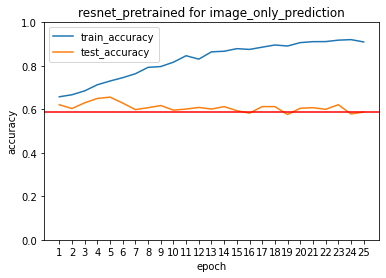

In [13]:
plt.plot(train_acc, label="train_accuracy")
plt.plot(test_acc, label="test_accuracy")
plt.axhline(Counter(emotion_train)[2]/len(emotion_train), color='red')
plt.title("resnet_pretrained for image_only_prediction")
plt.xlabel("epoch")
plt.xticks(range(25), range(1, 26))
plt.ylabel("accuracy")
plt.ylim(ymin=0, ymax=1)
plt.legend()
plt.savefig('./image_only_prediction_to_linear_probe.jpg')
plt.show()

### 观察bert模型预测结果

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Bert().to(device)
model.load_state_dict(torch.load("bert.kpl"))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [21]:
test_gold, test_pred = [], []
for _, idx, mask, target in test_dataloader:
    model.eval()
    idx, mask, target = idx.to(device), mask.to(device), target.to(device)
    output = model(idx, mask)
    test_gold.extend(target.tolist())
    test_pred.extend(torch.softmax(output, dim=1).tolist())

In [35]:
true_scores = []
false_scores = []
for i in range(len(test_gold)):
    gold = test_gold[i]
    pred = test_pred[i]
    if np.argmax(pred) == gold:
        true_scores.append(max(pred))
    else:
        false_scores.append(max(pred))

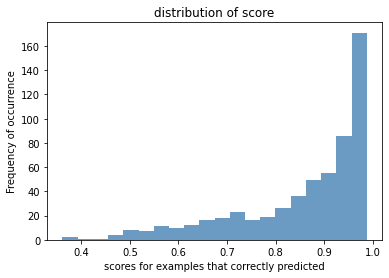

In [51]:
plt.hist(true_scores, bins=20, alpha=0.8, histtype='stepfilled', color='steelblue', edgecolor='none')
plt.title("distribution of score")
plt.xlabel("scores for examples that correctly predicted")
plt.ylabel("Frequency of occurrence")
plt.show()

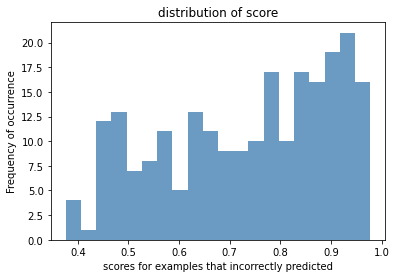

In [50]:
plt.hist(false_scores, bins=20, alpha=0.8, histtype='stepfilled', color='steelblue', edgecolor='none')
plt.title("distribution of score")
plt.xlabel("scores for examples that incorrectly predicted")
plt.ylabel("Frequency of occurrence")
plt.show()

### 查看困惑度比较大的图片以及文本

In [20]:
perplex_img = []
perplex_txt = []
perplex_emo = []
for img, idx, mask, target in test_dataloader:
    model.eval()
    idx, mask, target = idx.to(device), mask.to(device), target.to(device)
    output = model(idx, mask)
    output = torch.softmax(output, dim=1)
    for i in range(16):
        if max(output[i].tolist())<0.5 and np.argmax(output[i].tolist())!=target[i]:
            perplex_img.append(img[i].tolist())
            perplex_txt.append(token.decode(idx[i]))
            perplex_emo.append(target[i].tolist())
print(len(perplex_img))

33


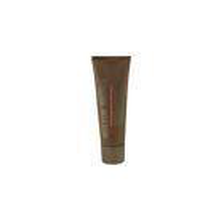

check this deal : http : / / t. co / umg4jusxwm # 9273 485461 molton
attitude is negative


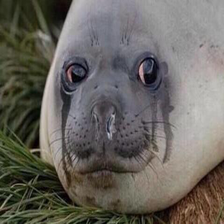

@ krackheadkac only listens to what she wants to hear? # neglected
attitude is negative


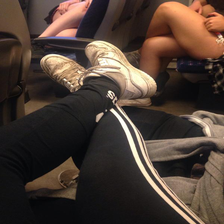

defeated by onedance # deathbygarage # deathbydnb
attitude is negative


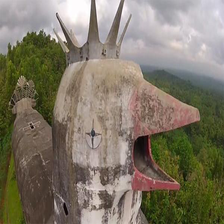

rt @ gotham3 : hidden deep in an indonesian jungle, there is a mysterious chicken shaped abandoned church. http : / / t. co / nc
attitude is neutral


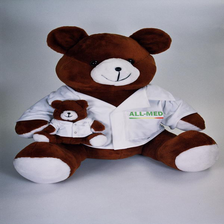

tak wygl? daj? maskotki reklamowe dla firmy z ofert? dla laboratoriow :
attitude is neutral


In [33]:
for i in range(5):
    picture = Image.fromarray(np.uint8(perplex_img[i]).transpose(1,2,0))
    picture.show()
    txt = " ".join(perplex_txt[i].replace('[CLS]', "").replace('[SEP]', "").replace('[PAD]', "").split(" "))
    emo = ['neutral', 'negative', 'positive']
    print(txt.strip())
    print("attitude is " + emo[perplex_emo[i]])

### 查看困惑度比较小的图片

In [26]:
no_perplex_img = []
no_perplex_txt = []
no_perplex_emo = []
for img, idx, mask, target in test_dataloader:
    model.eval()
    idx, mask, target = idx.to(device), mask.to(device), target.to(device)
    output = model(idx, mask)
    output = torch.softmax(output, dim=1)
    for i in range(16):
        if max(output[i].tolist())>0.9 and np.argmax(output[i].tolist())==target[i]:
            no_perplex_img.append(img[i].tolist())
            no_perplex_txt.append(token.decode(idx[i]))
            no_perplex_emo.append(target[i].tolist())
print(len(no_perplex_img))

300


In [29]:
for i in range(20):
    txt = " ".join(no_perplex_txt[i].replace('[CLS]', "").replace('[SEP]', "").replace('[PAD]', "").split(" ")).strip()
    print(txt)

rt @ hugosophiausa : lace top black skirt???? http : / / t. co / fftqakubkz
rt @ _ yongmoney : how it looks like to be judged by # top # bigbang # bigbangmadeinsg # madeinsg
making friends with a lovely bar tender at koi # gentleman # servicewithasmile # nightout # birthday # drinks # laughs
haha??? # herface # nooneononeforyou # crazy # bachelor # bachelornation # next @ abcnetwork
intrepid 2016 elite goes 9 - 2 - 1 on the summer season. way to rep the orange and blue! # intrepidfami
rt @ texastribune : video : dps officer became enraged over cigarette | @ sophiabollag & @ tlangford : http : /
you are made for loving me.
rt @ crazycatlady711 : @ megadeth the t - shirt i won came. super thrilled and proud to wear it. thank
ma porco cazzo, uma perch? pure te?! # chirurgiadiplasticadimerda # shocked
david beckham posted the cutest birthday tribute to his best girl
# flawed “ @ readyforhillary : " who run the world? girls. " # grammys
# finished!! plus de photos demain : ) # art # paintin